# Assignment 2
## Morteza Aghajanzadeh

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns

### 1. **Compute the characteristics**
I cleaned the data and merged the CRSP, Moody and Compustat in the data_cleaning.py 
Here I use the output from that code

In [122]:
# Load the cleaned and merged data
df = pd.read_csv('out/monthly_return_book_value.csv').drop(columns=['gvkey'])
df['B/M'] = df.BookEquity/df.mcap
df['B/M'] = df['B/M'].replace([np.inf, -np.inf], np.nan)
df['date'] = pd.to_datetime(df['date'])
df['month'] = df.date.dt.month
df.drop_duplicates(subset=['date', 'permno'], inplace=True)
df

,permno,date,prc,ret,shrout,year,prc_flag,mcap,BookEquity,B/M,month
0,10000,1985-12-31,NaN,NaN,NaN,1985,0,NaN,NaN,NaN,12
1,10000,1986-01-31,4.37500,NaN,3680.0,1985,1,0.016100,-0.000436,-0.027109,1
2,10000,1986-02-28,3.25000,-0.257143,3680.0,1985,1,0.011960,-0.000436,-0.036492,2
3,10000,1986-03-31,4.43750,0.365385,3680.0,1985,1,0.016330,-0.000436,-0.026727,3
4,10000,1986-04-30,4.00000,-0.098592,3793.0,1985,1,0.015172,-0.000450,-0.029650,4
...,...,...,...,...,...,...,...,...,...,...,...
5992408,93436,2023-08-31,258.07999,-0.034962,3173994.0,2023,0,819.144340,62.417544,0.076198,8
5992409,93436,2023-09-29,250.22000,-0.030456,3179000.0,2023,0,795.449380,62.515989,0.078592,9
5992410,93436,2023-10-31,200.84000,-0.197346,3178921.0,2023,0,638.454494,62.514435,0.097915,10
5992411,93436,2023-11-30,240.08000,0.195379,3178921.0,2023,0,763.195354,62.514435,0.081911,11


Find the Annual portfolio at the end of June

In [123]:
portfolio_selection = df.loc[df.month == 6].dropna(subset=['B/M'])
# portfolio_selection = portfolio_selection.loc[portfolio_selection['B/M'] > 0]
High_threshold = portfolio_selection.groupby('year')['B/M'].quantile(0.7).to_dict()
Low_threshold = portfolio_selection.groupby('year')['B/M'].quantile(0.3).to_dict()
High_portfolio = portfolio_selection.groupby('year').apply(lambda x: x.nlargest(30, 'B/M').permno.values).to_dict()
Low_portfolio = portfolio_selection.groupby('year').apply(lambda x: x.nsmallest(30, 'B/M').permno.values).to_dict()
 

C:\Users\SE.5203\AppData\Local\Temp\ipykernel_4352\883563885.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  High_portfolio = portfolio_selection.groupby('year').apply(lambda x: x.nlargest(30, 'B/M').permno.values).to_dict()
C:\Users\SE.5203\AppData\Local\Temp\ipykernel_4352\883563885.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Low_portfolio = portfolio_selection.groupby('year').apply(lambda x: 

Load the FF breakpoints

In [124]:
tempt = df.loc[df.month == 6].copy().drop_duplicates(subset=['date', 'permno']).reset_index(drop=True)
tempt['year'] = tempt.date.dt.year
positive_number = tempt.groupby('year')['B/M'].apply(lambda x: len(x[x >0])).to_dict()
total_number = tempt.groupby('year').size().to_dict()
negative_number = tempt.groupby('year')['B/M'].apply(lambda x: len(x[x <= 0])).to_dict()
tempt_df = pd.DataFrame([positive_number, negative_number, total_number], index=['positive', 'negative', 'total']).T
tempt_df.reset_index(inplace=True)
tempt_df.rename(columns={'index':'year'}, inplace=True)
tempt_df = tempt_df.melt(id_vars='year', value_vars=['positive', 'negative'])
tempt_df['data'] = 'our'

C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='year', ylabel='value'>

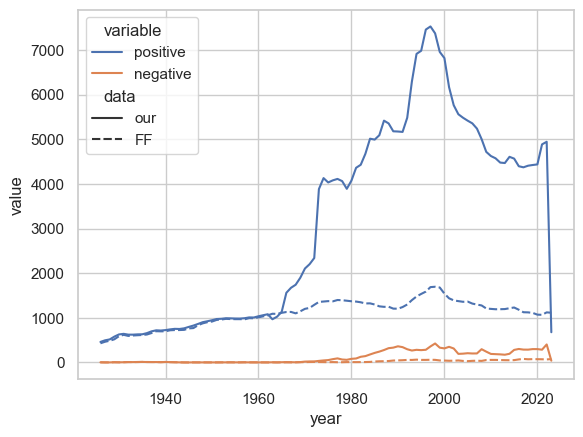

In [125]:
raw_df_breakpoint_FF = pd.read_csv('Data/BE-ME_Breakpoints.csv')
raw_df = raw_df_breakpoint_FF[['year','<=0',">0"]].copy().rename(columns={'<=0':'negative', '>0':'positive'})
raw_df['year'] = raw_df['year'].astype(int)
raw_df['data'] = 'FF'
raw_df = raw_df.melt(id_vars=['year', 'data'], value_vars=['positive', 'negative'])
merged_df = pd.concat([tempt_df, raw_df])
sns.lineplot(data=merged_df, x='year', y='value', hue='variable', style='data')

In [126]:
df_breakpoint_FF = raw_df_breakpoint_FF[['year','0.3','0.7']].copy()
df_breakpoint_FF.columns = ['year','Growth','Value']
df_breakpoint_FF['year'] = df_breakpoint_FF['year'].astype(int)
df_breakpoint_FF = df_breakpoint_FF.melt(id_vars='year', value_vars=['Growth', 'Value'], var_name='Threshold', value_name='B/M').sort_values(by=['year', 'Threshold']).reset_index(drop=True)
df_breakpoint_FF['calculation'] = 'FF'

In [127]:
df_breakpoint = pd.DataFrame({'High_threshold': High_threshold, 'Low_threshold': Low_threshold})
df_breakpoint = df_breakpoint.reset_index()
df_breakpoint.rename(columns={'index': 'year'}, inplace=True)
df_breakpoint = df_breakpoint.melt(id_vars='year', value_vars=['High_threshold', 'Low_threshold'], var_name='Threshold', value_name='B/M')
df_breakpoint['Threshold'] = df_breakpoint.Threshold.map({'High_threshold': 'Value', 'Low_threshold': 'Growth'})
df_breakpoint['calculation'] = 'Our'

C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SE.5203\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'B/M Breakpoint')

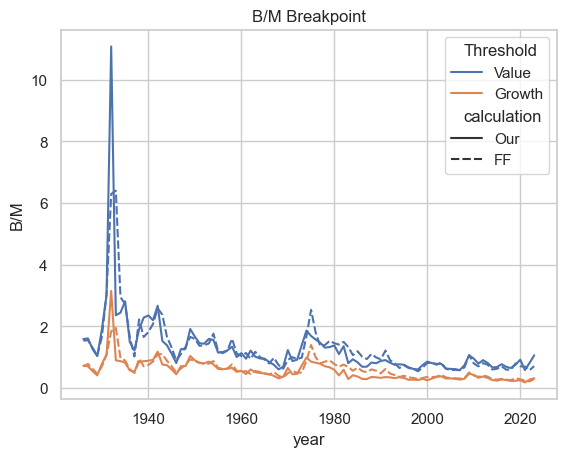

In [128]:
df_breakpoint = pd.concat([df_breakpoint, df_breakpoint_FF], ignore_index=True)
sns.set(style="whitegrid")
ax = sns.lineplot(x="year", y="B/M", hue="Threshold", style="calculation", data=df_breakpoint)
ax.set_title('B/M Breakpoint')

## Q2
Done in the cleaning part

## Q3

High_portfolio

In [129]:
High_portfolio, Low_portfolio

({1926: array([10583, 12642, 13194, 13960, 13071, 15560, 15202, 14971, 13717,
         11172, 12714, 11420, 11439, 11228, 10073, 10663, 15317, 10882,
         15413, 11332, 17873, 10452, 10444, 15106, 75471, 15034, 15384,
         13418, 14648, 11519], dtype=int64),
  1927: array([13071, 14330, 13960, 13194, 15560, 15413, 14971, 13813, 10073,
         10014, 13506, 11412, 75471, 10452, 11201, 11228, 11172, 11439,
         14920, 15202, 11519, 10436, 10647, 11797, 12474, 10399, 16037,
         10356, 11551, 10639], dtype=int64),
  1928: array([13071, 13194, 14971, 11201, 11797, 15042, 14293, 11519, 10452,
         13960, 15202, 11551, 15560, 14920, 11439, 11332, 14912, 75471,
         12474, 13506, 11172, 14330, 13485, 16037, 10794, 26972, 13995,
         15333, 15034, 13530], dtype=int64),
  1929: array([10815, 13071, 13194, 11797, 11578, 13960, 15042, 11551, 14293,
         14971, 11201, 10452, 12474, 14920, 13004, 15560, 11332, 16037,
         16221, 14787, 11172, 10700, 15771, 13485

In [134]:
monthly_return_df = df.dropna(subset=['mcap','ret']).copy()


In [135]:
for i in tqdm(High_portfolio):
    print(i)

1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
